# Example Usage  

The example usage of the **dynamic_multiplier** includes:  

1. Create or load a DataFrame.  
2. Initialise the function.  
3. Run the estimation.
4. Interpret the results.

## 1 - Loading a DataFrame

In [9]:
import pandas as pd
df = pd.read_excel('/Users/thomaswoodhead/Documents/DynamMultPhDV2.xlsx')

## 2 - Initialise the Function  

This may be simply copy and pasted. 

In [14]:
def dynamic_multiplier(
    df,
    endog_vars,
    exog_vars,
    endog_lags,
    exog_lags,
    horizons,
    constant=True,
    alpha=0.05,
    round_digits=4,
    plot_style="individual",
    color="blue"
):

    """
    Estimate dynamic multipliers from a VAR-X or Reduced Form SVAR-X setup using OLS, capturing
    how a change in an exogenous variable affects endogenous variables over time.

    This function computes and plots the dynamic response of each endogenous variable
    to exogenous shocks over a specified horizon, based on lag-augmented OLS regressions. It also
    constructs confidence intervals using the delta method.

    Parameters
    ----------
    df : pandas.DataFrame
        The input dataframe containing all endogenous and exogenous variables.

    endog_vars : list of str
        Names of the endogenous variables.

    exog_vars : list of str
        Names of the exogenous variables.

    endog_lags : int
        Number of lags for endogenous variables (start from lag 1).

    exog_lags : int
        Number of lags for exogenous variables (including lag 0).

    horizons : int
        Number of horizons (time periods) to compute dynamic multipliers.

    include_constant : bool, default=True
        Whether to include a constant term in the OLS regressions.

    ci : bool, default=True
        Whether to compute confidence intervals.

    ci_level : float, default=0.95
        Confidence level for interval bands (e.g., 0.95 for 95% CI).

    plot : bool, default=True
        Whether to plot the dynamic multipliers.

    plot_style : {'individual', 'grid'}, default='individual'
        Plot format: 'individual' plots one chart per response; 'grid' arranges them in a matrix.

    color : str, default='blue'
        Line color for the impulse response plots.

    round_decimals : int, default=4
        Number of decimals to round the output table.

    Returns
    -------
    multiplier_table : pandas.DataFrame
        A long-format DataFrame containing point estimates and optional confidence intervals
        for each (endogenous, exogenous, horizon) combination.

    multipliers : numpy.ndarray
        A 3D array of shape (horizons + 1, n_endog, n_exog) with dynamic multiplier values.

    std_errors : numpy.ndarray or None
        Standard errors of the dynamic multipliers if `ci=True`, else None.

    Notes
    -----
    - Lag creation uses `df.shift`, so rows with NaNs due to lagging are dropped before regression.
    - Confidence intervals are computed using the delta method assuming normality.
    - Plotting uses `matplotlib` and adjusts layout automatically.
    """
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.regression.linear_model import OLS
    import statsmodels.api as sm
    from scipy.stats import norm

    # Lag Construction 
    def create_lags(df, lags, columns, start_lag=1):
        lagged_data = []
        for lag in range(start_lag, lags + 1):
            lagged = df[columns].shift(lag).copy()
            lagged.columns = [f"{col}_lag{lag}" for col in columns]
            lagged_data.append(lagged)
        return pd.concat(lagged_data, axis=1)

    lagged_endog = create_lags(df, endog_lags, endog_vars, start_lag=1)
    lagged_exog = create_lags(df, exog_lags, exog_vars, start_lag=0)

    X = pd.concat([lagged_endog, lagged_exog], axis=1)
    data = pd.concat([df[endog_vars], X], axis=1).dropna()
    X = X.loc[data.index]
    if constant:
        X = sm.add_constant(X)

    # OLS Estimation 
    results = {}
    for var in endog_vars:
        y = data[var]
        model = OLS(y, X).fit()
        results[var] = model

    n_endog = len(endog_vars)
    n_exog = len(exog_vars)
    z_score = norm.ppf(1 - alpha / 2)

    # Build each matrix from the parameters estimated by OLS
    R1_lags = []
    for lag in range(1, endog_lags + 1):
        A = np.zeros((n_endog, n_endog))
        for i, dep_var in enumerate(endog_vars):
            coef = results[dep_var].params
            for j, regressor in enumerate(endog_vars):
                A[i, j] = coef.get(f"{regressor}_lag{lag}", 0.0)
        R1_lags.append(A)

    R2_lags = []
    for lag in range(0, exog_lags + 1):
        B = np.zeros((n_endog, n_exog))
        for i, dep_var in enumerate(endog_vars):
            coef = results[dep_var].params
            for j, regressor in enumerate(exog_vars):
                B[i, j] = coef.get(f"{regressor}_lag{lag}", 0.0)
        R2_lags.append(B)

    # Compute Dynamic Multipliers 
    multipliers = np.zeros((horizons + 1, n_endog, n_exog))
    for h in range(horizons + 1):
        if h == 0:
            multipliers[h] = R2_lags[0]
        else:
            total = np.zeros((n_endog, n_exog))
            for i in range(1, min(h, endog_lags) + 1):
                total += R1_lags[i - 1] @ multipliers[h - i]
            if h <= exog_lags:
                total += R2_lags[h]
            multipliers[h] = total

    # Compute Standard Errors and Confidence Intervals
    std_errors = np.zeros_like(multipliers)
    for h in range(horizons + 1):
        for i_endog, endog in enumerate(endog_vars):
            model = results[endog]
            cov = model.cov_params()
            for i_exog, exog in enumerate(exog_vars):
                if h == 0:
                    param = f"{exog}_lag0"
                    try:
                        std_errors[h, i_endog, i_exog] = np.sqrt(cov.loc[param, param])
                    except KeyError:
                        std_errors[h, i_endog, i_exog] = np.nan
                else:
                    variance_sum = 0.0
                    for lag in range(0, min(h + 1, exog_lags + 1)):
                        param = f"{exog}_lag{lag}"
                        if h - lag >= 0:
                            weight = multipliers[h - lag, i_endog, i_exog]
                            try:
                                var = cov.loc[param, param]
                                variance_sum += (weight ** 2) * var
                            except KeyError:
                                continue
                    std_errors[h, i_endog, i_exog] = np.sqrt(variance_sum)

    lower = multipliers - z_score * std_errors
    upper = multipliers + z_score * std_errors

    # Plot IRFs 
    if plot_style == "grid":
        fig, axs = plt.subplots(n_endog, n_exog, figsize=(12, 8), sharex=True)
        for i in range(n_endog):
            for j in range(n_exog):
                ax = axs[i, j]
                ax.plot(range(horizons + 1), multipliers[:, i, j], label=f"{endog_vars[i]} to {exog_vars[j]}", color=color)
                ax.fill_between(range(horizons + 1), lower[:, i, j], upper[:, i, j], color=color, alpha=0.3)
                ax.axhline(0, color='black', linewidth=0.5)
                ax.set_title(f'Responce of {endog_vars[i]} to {exog_vars[j]}')
                ax.set_xlabel("Horizon")
                ax.set_ylabel("Effect")
        plt.tight_layout()
        plt.show()

    elif plot_style == "individual":
        for i_endog, endog in enumerate(endog_vars):
            for i_exog, exog in enumerate(exog_vars):
                plt.figure(figsize=(8, 4))
                plt.plot(range(horizons + 1), multipliers[:, i_endog, i_exog], label='IRF', color=color)
                plt.fill_between(
                    range(horizons + 1),
                    lower[:, i_endog, i_exog],
                    upper[:, i_endog, i_exog],
                    color=color,
                    alpha=0.3,
                    label=f'{100*(1-alpha):.0f}% CI'
                )
                plt.axhline(0, color='grey', linestyle='--', linewidth=1)
                plt.title(f'IRF: {endog} response to {exog}')
                plt.xlabel('Horizon')
                plt.ylabel('Response')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

    # Tabulate Results
    records = []
    for h in range(horizons + 1):
        for i_endog, endog in enumerate(endog_vars):
            for i_exog, exog in enumerate(exog_vars):
                records.append({
                    "Horizon": h,
                    "Endogenous": endog,
                    "Exogenous": exog,
                    "Dynamic Multiplier": multipliers[h, i_endog, i_exog],
                    "95% CI Lower": lower[h, i_endog, i_exog],
                    "95% CI Upper": upper[h, i_endog, i_exog]
                })

    multiplier_table = pd.DataFrame(records)
    return multiplier_table.round(round_digits)


## 3 - Run the Estimation  

Please note that this model is neither well-specified nor robust and lacks theoretical foundations. The variables have been selected arbitrarily solely to demonstrate the output. Nonetheless, this model estimates how shocks to oil stock (stock) and industrial production (ip) influence the interest rate (ir) and renewable energy generation (ren) over 10 horizons. A significance level of 95% (alpha = 0.05) has been chosen, with both endogenous and exogenous variables incorporating a lag length of 11 periods.

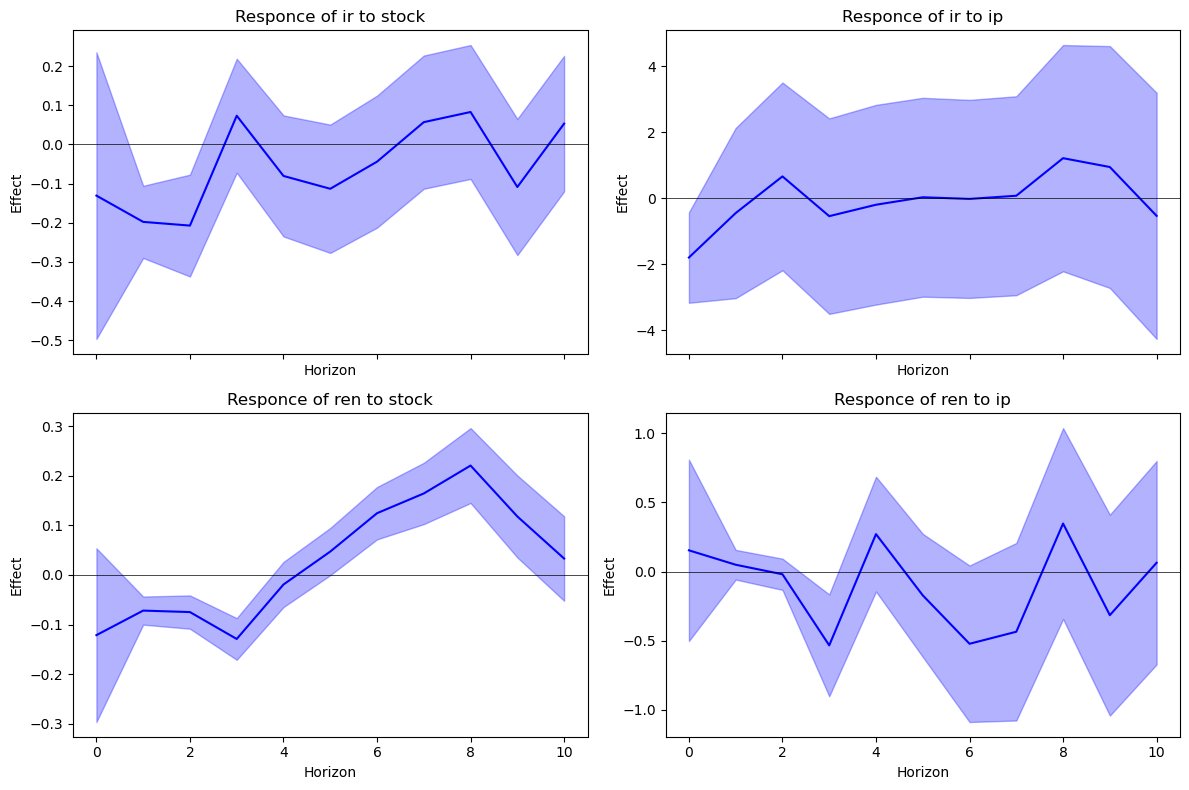

    Horizon Endogenous Exogenous  Dynamic Multiplier  95% CI Lower  \
0         0         ir     stock             -0.1307       -0.4967   
1         0         ir        ip             -1.7942       -3.1655   
2         0        ren     stock             -0.1214       -0.2966   
3         0        ren        ip              0.1534       -0.5028   
4         1         ir     stock             -0.1978       -0.2900   
5         1         ir        ip             -0.4473       -3.0266   
6         1        ren     stock             -0.0719       -0.1003   
7         1        ren        ip              0.0491       -0.0583   
8         2         ir     stock             -0.2072       -0.3372   
9         2         ir        ip              0.6634       -2.1815   
10        2        ren     stock             -0.0749       -0.1085   
11        2        ren        ip             -0.0199       -0.1329   
12        3         ir     stock              0.0733       -0.0722   
13        3         

In [32]:
multiplier_df = dynamic_multiplier(
    df=df,                         # Required: pandas DataFrame containing all variables
    endog_vars=['ir', 'ren'],      # Required: list of endogenous variable names
    exog_vars=['stock', 'ip'],     # Required: list of exogenous variable names
    endog_lags=11,                 # Required: number of lags for endogenous variables (start lag 1)
    exog_lags=11,                  # Required: number of lags for exogenous variables (including lag 0)
    horizons=10,                   # Required: number of time horizons to compute multipliers over

    constant=True,                # Optional (default=True): include constant term in OLS
    alpha=0.05,                   # Optional (default=0.05): significance level for confidence intervals
    round_digits=4,               # Optional (default=4): decimal places to round output table
    plot_style="grid",      # Optional (default='individual'): 'individual' or 'grid' plot style
    color="blue"                  # Optional (default='blue'): color for the plots
)

print(multiplier_df)


## 4 - Interpreting the results  

In the plots, the thin, dark blue lines represent the estimated dynamic multipliers at each horizon, illustrating the temporal impact of a shock to an exogenous variable. The lighter blue shading around these lines indicates the confidence intervals. For any given horizon, if zero lies within the shaded region, the dynamic multiplier is considered statistically insignificant at the 5% significance level.

For example, in Plot 1, the dynamic multipliers are statistically significant—i.e., different from zero at the 5% level—only at the second and third horizons. Since these significant multipliers are negative, this suggests that an increase in oil stocks leads to a reduction in the interest rate during these time periods.